In [1]:
import keras


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator
import numpy as np

Using TensorFlow backend.


In [2]:
import numpy as np
import sys

#keras imports 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, one_hot, text_to_word_sequence

from keras.layers import Dense, Input, Flatten, Reshape, concatenate, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Embedding
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Embedding
from keras.layers import LSTM, Bidirectional

from keras.models import Model, Sequential

from keras import optimizers
from keras import regularizers

from keras.preprocessing.text import Tokenizer, one_hot, text_to_word_sequence

from keras.wrappers.scikit_learn import KerasClassifier # Keras wrapper to scikit learn used for pipes.





In [3]:
##Import Libraries##
import pandas as pd
 

#General libraries

import random

import string

import re

import pandas as pd

import numpy as np

import itertools

import matplotlib.pyplot as plt

from nltk import PorterStemmer

from collections import Counter, defaultdict

 


#Keras front end

import keras

from keras.preprocessing.text import Tokenizer, one_hot, text_to_word_sequence

from keras.preprocessing.sequence import pad_sequences

from keras.models import Model, Sequential

from keras.layers import Dense, Embedding, Bidirectional, LSTM, Flatten, Dropout, Input, Conv1D, MaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier # Keras wrapper to scikit learn used for pipes.

 

#Sci-kit learn

import sklearn

from sklearn.pipeline import make_pipeline, TransformerMixin

from sklearn.base import BaseEstimator

from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA

from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import BaggingClassifier

from sklearn.svm import SVC

 


In [4]:
import os
os.chdir("/home/spenser/Downloads/")
complaints = pd.read_csv("complaints.csv")

# Create Target Variable :

 

#Target variable used throughout this demonstration will be whether or not the complaint was listed by the CFPB as

#a mortgage complaint(1) or any other product (0).

complaints['mortgage'] = np.where(complaints['Product']=='Mortgage', 1, 0)

 
complaints = complaints[1:20000]


/home/spenser/anaconda3/envs/gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
len(complaints)

368127

In [ ]:


#Process Complaints data.

complaints['comments_lower'] = complaints['Consumer complaint narrative'].str.lower() # Set complaints string to lower case.

complaints['comments_lower'] = complaints['comments_lower'].str.replace('\d+', '') #remove numbers

complaints['comments_lower'] =complaints['comments_lower'].str.replace(r'(.)\1{2,}', '')

 

### Define function to remove punction from text.

 

def remove_punctuations(text):

    for punctuation in string.punctuation:

        text = text.replace(punctuation, '')

    return text

complaints['comments_lower'] = complaints['comments_lower'].apply(remove_punctuations)  #remove punctuation



In [ ]:

 

#Remove single stand-alone characters. ("a", "e", etc)

complaints['comments_lower'] = complaints['comments_lower'].str.replace(r'\b(?<=)[a-z](?=)\b', '') #remove single stand-alone characters.

 

#Removes characters that repeat more than 3 times. "e.g., XXXXXX"

complaints['comments_lower'] = [re.sub('^(.+?)\3+$', "", x) for x in complaints['comments_lower']]

complaints['comments_lower'] = [re.sub("xx", "", x) for x in complaints['comments_lower']]

 

# Remove stop words.

#complaints['stopwords'] = complaints['comments_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (ENGLISH_STOP_WORDS)])) #stop word removal.

 

stemmer = PorterStemmer()  #Initialize stemmer function

 

#Stemming operator

def stem_documents(sentence):

    tokens = sentence.split()

    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(stemmed_tokens)

 

complaints['stemmed'] = complaints['comments_lower'].apply(stem_documents) # Apply stemming

 

fullcorpus = ' '.join(complaints['stemmed']) ###Determine vocabulary size

#memory limtis... setting to arbitrary 300k for now
words = 300000

vocab_size = len(words)

 

word_occurences = fullcorpus.split()   #Gather words that

c = Counter(word_occurences)

In [100]:

#memory limtis... setting to arbitrary 300k for now
#words = 300000

vocab_size = 10000

 

word_occurences = fullcorpus.split()   #Gather words that

c = Counter(word_occurences)

In [101]:


#limit feature space ... commonly occuring words 
vocab_lf = set([model for model in word_occurences if c[model] in {1,2,3, 4, 5, 7, 8, 9,10}])

 

# Remove infrequent words.

complaints['sparse'] = complaints['stemmed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (vocab_lf)])) #remove sparse terms

 

complaints['wc'] = complaints['sparse'].str.count(' ') + 1 #count words in each document.

 

complaints_wc = complaints[complaints['wc'] > 15] ### Keep all documents with word count above 10.

 

### Create test/train split for the training data (texts) and target (1 = mortgage, 0 = not a mortgage)

texts_train, texts_test, y_train, y_test = train_test_split(complaints_wc['sparse'].values.tolist(), complaints_wc['mortgage'].values.tolist(), random_state = 40)

 

In [7]:
max_features = 100000

In [63]:
import tensorflow as tf
from keras import backend as K

num_cores = 12




config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 12}
                       )

session = tf.Session(config=config)
K.set_session(session)

In [64]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16578136999466466827, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1866966072122282250
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 425358027550572257
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10913228391
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9469803708977618964
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 7505844634
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11127568901349150480
 physical_device_desc: "device: 1, name: GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1"]

In [5]:

#Filters(32) and LSTM memory units chosen arbitrarily(50), batch size, etc but the model could be improved by grid searching some of these hyperparameters.

#other values of kernel size could be experimented with.

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Convolution1D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
import numpy as np

from tensorflow import set_random_seed
set_random_seed(2)
from deepexplain.tensorflow import DeepExplain
from keras.layers import Activation
from keras import backend as K
max_review_length = 700

import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
#import tensorflow as tf
#config = tf.ConfigProto(allow_soft_placement=True)
#config.gpu_options.allocator_type = 'BFC'
#config.gpu_options.per_process_gpu_memory_fraction = 0.80
#set_session(sess)  # set this TensorFlow session as the default 

current_session = K.get_session() 

 

max_features = 10000

 

##########################

with DeepExplain(session=current_session) as de:  # <-- init DeepExplain context
    complaints['comments_lower'] = complaints['Consumer complaint narrative'].str.lower() # Set complaints string to lower case.

    complaints['comments_lower'] = complaints['comments_lower'].str.replace('\d+', '') #remove numbers

    complaints['comments_lower'] =complaints['comments_lower'].str.replace(r'(.)\1{2,}', '')



    ### Define function to remove punction from text.



    def remove_punctuations(text):

        for punctuation in string.punctuation:

            text = text.replace(punctuation, '')

        return text

    complaints['comments_lower'] = complaints['comments_lower'].apply(remove_punctuations)  #remove punctuation

 

 

    #Remove single stand-alone characters. ("a", "e", etc)

    complaints['comments_lower'] = complaints['comments_lower'].str.replace(r'\b(?<=)[a-z](?=)\b', '') #remove single stand-alone characters.



    #Removes characters that repeat more than 3 times. "e.g., XXXXXX"

    complaints['comments_lower'] = [re.sub('^(.+?)\3+$', "", x) for x in complaints['comments_lower']]

    complaints['comments_lower'] = [re.sub("xx", "", x) for x in complaints['comments_lower']]



    # Remove stop words.

    #complaints['stopwords'] = complaints['comments_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (ENGLISH_STOP_WORDS)])) #stop word removal.



    stemmer = PorterStemmer()  #Initialize stemmer function



    #Stemming operator

    def stem_documents(sentence):

        tokens = sentence.split()

        stemmed_tokens = [stemmer.stem(token) for token in tokens]

        return ' '.join(stemmed_tokens)



    #complaints['stemmed'] = complaints['comments_lower'].apply(stem_documents) # Apply stemming



    fullcorpus = ' '.join(complaints['comments_lower']) ###Determine vocabulary size


    word_occurences = fullcorpus.split()   #Gather words that

    c = Counter(word_occurences)


    vocab_size = 20000
    
    

    #limit feature space ... commonly occuring words 
    vocab_lf = set([model for model in word_occurences if c[model] in {1,2,3, 4, 5, 7, 8, 9,10}])



    # Remove infrequent words.

    complaints['sparse'] = complaints['comments_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (vocab_lf)])) #remove sparse terms



    complaints['wc'] = complaints['sparse'].str.count(' ') + 1 #count words in each document.



    complaints_wc = complaints[complaints['wc'] > 15] ### Keep all documents with word count above 10.



    ### Create test/train split for the training data (texts) and target (1 = mortgage, 0 = not a mortgage)

    texts_train, texts_test, y_train, y_test = train_test_split(complaints_wc['sparse'].values.tolist(), complaints_wc['mortgage'].values.tolist(), random_state = 40)

 

    class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):

        def __init__(self,  **kwargs):

            super().__init__(**kwargs)



        def fit(self, texts, y=None):

            self.fit_on_texts(texts)

            return self



        def transform(self, texts, y = None):

            return np.array(self.texts_to_sequences(texts))





    sequencer = TextsToSequences(num_words=vocab_size)



            ### Function to pad sequences. Padding constrains all input vectors to be the same length.


    maxlen = 625
    class Padder(BaseEstimator, TransformerMixin):



        def __init__(self, maxlen=maxlen):

            self.maxlen = maxlen

            self.max_index = None



        def fit(self, X, y=None):

            self.max_indent = pad_sequences(X, maxlen=self.maxlen).max()

            return self



        def transform(self, X, y=None):

            X = pad_sequences(X, maxlen=self.maxlen)

                        #X[X > self.max_index] = 0

            return X





    padder = Padder(maxlen)

    ######################
    def create_model(max_features):
           #Process Complaints data.

        
            maxlen = 625
            max_review_length = 625

            ### Function to create sequences from text for LSTM input.



            class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):

                def __init__(self,  **kwargs):

                    super().__init__(**kwargs)



                def fit(self, texts, y=None):

                    self.fit_on_texts(texts)

                    return self



                def transform(self, texts, y = None):

                    return np.array(self.texts_to_sequences(texts))





            sequencer = TextsToSequences(num_words=vocab_size)



            ### Function to pad sequences. Padding constrains all input vectors to be the same length.



            class Padder(BaseEstimator, TransformerMixin):

           

                def __init__(self, maxlen=maxlen):

                    self.maxlen = maxlen

                    self.max_index = None



                def fit(self, X, y=None):

                    self.max_indent = pad_sequences(X, maxlen=self.maxlen).max()

                    return self



                def transform(self, X, y=None):

                    X = pad_sequences(X, maxlen=self.maxlen)

                    #X[X > self.max_index] = 0

                    return X





            padder = Padder(maxlen)



            max_features = vocab_size + 1

            
        #################

            embedding_vecor_length = 100

            model = None #

            model = Sequential()

            model.add(Embedding(max_features, embedding_vecor_length, input_length=max_review_length))
            model.add(Convolution1D(64, 3, padding='same'))
            model.add(Convolution1D(32, 3, padding='same'))
            model.add(Convolution1D(16, 3, padding='same'))
            model.add(Flatten())
            model.add(Dropout(0.2))
            model.add(Dense(180,activation='tanh'))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='tanh'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            #model.fit(texts_train, y_train, epochs=3)
            
            return model
    
    sklearn_cnn = KerasClassifier(build_fn=create_model, epochs = 2, batch_size =1, validation_split = 0.2, shuffle=False,  max_features=max_features, verbose = 1)
    
    #Using sklearn pipeline to bring the model together and do the training.

    pipeline = make_pipeline(sequencer, padder, sklearn_cnn)

 

    pipeline.fit(texts_train, y_train)

    y_pred = pipeline.predict(texts_test)
    
  

    
        #get sequenced and padded y_test

    maxlen = 625
    max_review_length = 625
    

                ### Function to create sequences from text for LSTM input.



    

    sequences_x_test = sequencer.fit_transform(texts_test)

    padded_sequences_x_test = padder.fit_transform(sequences_x_test)


    #make sure this is really supposed to be x_test... corresponds to the input tensor below
    xs = padded_sequences_x_test;
    ys = y_test;
    
    # Evaluate the embedding tensor on the model input (in other words, perform the lookup)
    embedding_tensor = pipeline._final_estimator.model.layers[0].output
    input_tensor = pipeline._final_estimator.model.inputs[0]
    
    xst = tf.convert_to_tensor(xs, dtype=tf.float32)
    ## is this looking at x_test values against the embedding layer? So, imbedding layer lookup
    embedding_out = current_session.run(embedding_tensor, {input_tensor: xs});
    #from later output, this matches shape of embedding layer (4836, 625, 100)
    
    #model.layers[-1].output  this is output of the last dense layer * y_test (value of y_test)
     #Run DeepExplain with the embedding as input
    
    
    #pipeline._final_estimator.model.layers[-1].output takes shape of last later ... dense layer, where activation function occurs ... SO, where probabilities are transformed... 
    attributions = de.explain('elrp', pipeline._final_estimator.model.layers[-1].output * ys, pipeline._final_estimator.model.layers[1].input, embedding_out);
    


Train on 11605 samples, validate on 2902 samples
Epoch 1/2
11605/11605 [==============================] - 93s 8ms/step - loss: 3.0695 - acc: 1.7234e-04 - val_loss: 3.0492 - val_acc: 0.0000e+00
Epoch 2/2
4836/4836 [==============================] - 7s 1ms/step
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  False


In [6]:
 print("embedding_tensor --- {}".format(embedding_tensor));

embedding_tensor --- Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, 625, 100), dtype=float32)


In [7]:
attributions

array([[[ 0.03605426, -0.0371699 ,  0.00037402, ...,  0.02553978,
         -0.02378708, -0.00031224],
        [-0.02593805, -0.06705971, -0.00032729, ...,  0.00911739,
         -0.0775394 ,  0.0233367 ],
        [-0.02931068,  0.01447556,  0.00105111, ..., -0.0146676 ,
         -0.0218953 ,  0.01662475],
        ...,
        [-0.02551593,  0.01570912,  0.05392259, ..., -0.00994319,
          0.0061694 ,  0.00407895],
        [-0.01579349, -0.01285986, -0.01071473, ..., -0.06527746,
          0.00513878,  0.02913485],
        [ 0.01101012, -0.00253973, -0.05041096, ..., -0.00474725,
         -0.06402731,  0.01386152]],

       [[ 0.03753682, -0.03831011,  0.00038188, ...,  0.02632095,
         -0.02503867, -0.0002558 ],
        [-0.02684977, -0.06936224, -0.00034506, ...,  0.00929979,
         -0.0808247 ,  0.02426811],
        [-0.03036709,  0.01408448,  0.0011079 , ..., -0.01486071,
         -0.02255842,  0.01740289],
        ...,
        [ 0.00281909, -0.00315055, -0.03897113, ...,  

In [8]:
embedding_out.shape # matches shape of embedding layer

(4836, 625, 100)

In [15]:
padded_sequences_x_test[11]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [20]:
####Sums the attributions since the original attributions are in the context of word embeddings (499, 900, 300) --> (499,900)
import numpy as np 
sum_attributions = np.sum(attributions, -1)
sum_attributions[11].shape

(625,)

In [21]:
len(sum_attributions[11])
len(texts_test[11])
#7---8   -3.49303198e+00
#6---12  9.31932628e-02

496

In [22]:
first_all_test = attributions[11]
first_all_test

array([[ 0.03644802, -0.03740307,  0.00037263, ...,  0.02556981,
        -0.02404201, -0.00034754],
       [-0.02625288, -0.06749385, -0.00032367, ...,  0.00911451,
        -0.07777835,  0.02345118],
       [-0.02923287,  0.01427176,  0.0010533 , ..., -0.01479445,
        -0.02204945,  0.01674063],
       ...,
       [-0.01629188, -0.01006323, -0.00241213, ..., -0.02178553,
         0.12943889, -0.00212846],
       [ 0.00151205, -0.07779945, -0.03775677, ..., -0.00754451,
        -0.05866285, -0.05393815],
       [ 0.00514054, -0.00565922,  0.02589317, ..., -0.02655172,
        -0.07895245,  0.00029446]], dtype=float32)

In [26]:

###attribution shape corresponds to max review length 
first_all_test = sum_attributions[11]
first_all_test.shape

(625,)

In [27]:
a = first_all_test
s = int(np.sqrt(first_all_test.size))
b = first_all_test.reshape(s, s)

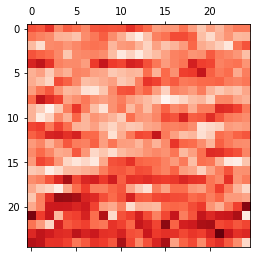

In [28]:

#plots as nxn array of the original
plt.matshow(b, cmap=plt.cm.Reds)
plt.show()

In [58]:
a = np.arange(1, 10)
s = int(np.sqrt(a.size))
b = a.reshape(s, s)

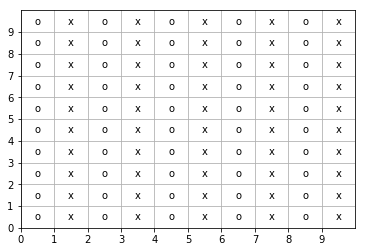

In [71]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

min_val, max_val = 0, 10
ind_array = np.arange(min_val + 0.5, max_val + 0.5, 1.0)
x, y = np.meshgrid(ind_array, ind_array)

for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
    c = 'x' if i%2 else 'o' 
    ax.text(x_val, y_val, c, va='center', ha='center')
#alternatively, you could do something like
#for x_val, y_val in zip(x.flatten(), y.flatten()):
#    c = 'x' if (x_val + y_val)%2 else 'o'

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_xticks(np.arange(max_val))
ax.set_yticks(np.arange(max_val))
ax.grid()

In [73]:
y

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
       [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
       [3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
       [4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5],
       [5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5],
       [6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5],
       [7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5],
       [8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5],
       [9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5]])

In [62]:
first_all_test

array([-4.84619141e-02, -4.77611721e-02,  1.14585504e-01, -1.14303879e-01,
        8.71682167e-03,  6.15034029e-02,  9.76834446e-02,  2.90975496e-02,
       -8.73301402e-02,  1.01986602e-02,  1.03009537e-01, -6.57228380e-02,
        2.68779323e-02,  2.42463872e-02,  8.03957731e-02,  4.57569063e-02,
       -1.00330472e-01, -7.02604949e-02,  1.72738925e-01,  3.07424441e-02,
       -2.60727666e-02,  3.80617287e-03, -1.37916282e-02, -3.73548307e-02,
        8.72188359e-02,  6.21738806e-02, -8.55469778e-02,  8.08393955e-02,
        3.90029997e-02, -7.22088367e-02,  5.28148673e-02,  7.21914321e-02,
        9.32469219e-02, -5.37336245e-02, -6.17521629e-02,  9.44258571e-02,
       -1.55012533e-02, -5.33264130e-03,  6.55182153e-02,  6.12401813e-02,
        7.98279047e-03, -4.40871343e-02,  2.20443159e-02,  1.81102037e-01,
        6.02827445e-02, -1.01982199e-01, -3.68011147e-02, -1.25124753e-02,
        1.05437666e-01,  1.42239168e-01, -1.93332434e-01,  9.06709954e-02,
        1.11118652e-01, -

In [63]:
b

array([[-4.84619141e-02, -4.77611721e-02,  1.14585504e-01,
        -1.14303879e-01,  8.71682167e-03,  6.15034029e-02,
         9.76834446e-02,  2.90975496e-02, -8.73301402e-02,
         1.01986602e-02,  1.03009537e-01, -6.57228380e-02,
         2.68779323e-02,  2.42463872e-02,  8.03957731e-02,
         4.57569063e-02, -1.00330472e-01, -7.02604949e-02,
         1.72738925e-01,  3.07424441e-02, -2.60727666e-02,
         3.80617287e-03, -1.37916282e-02, -3.73548307e-02,
         8.72188359e-02,  6.21738806e-02, -8.55469778e-02,
         8.08393955e-02,  3.90029997e-02, -7.22088367e-02],
       [ 5.28148673e-02,  7.21914321e-02,  9.32469219e-02,
        -5.37336245e-02, -6.17521629e-02,  9.44258571e-02,
        -1.55012533e-02, -5.33264130e-03,  6.55182153e-02,
         6.12401813e-02,  7.98279047e-03, -4.40871343e-02,
         2.20443159e-02,  1.81102037e-01,  6.02827445e-02,
        -1.01982199e-01, -3.68011147e-02, -1.25124753e-02,
         1.05437666e-01,  1.42239168e-01, -1.93332434e-

In [49]:
b

array([[-4.84619141e-02, -4.77611721e-02,  1.14585504e-01,
        -1.14303879e-01,  8.71682167e-03,  6.15034029e-02,
         9.76834446e-02,  2.90975496e-02, -8.73301402e-02,
         1.01986602e-02,  1.03009537e-01, -6.57228380e-02,
         2.68779323e-02,  2.42463872e-02,  8.03957731e-02,
         4.57569063e-02, -1.00330472e-01, -7.02604949e-02,
         1.72738925e-01,  3.07424441e-02, -2.60727666e-02,
         3.80617287e-03, -1.37916282e-02, -3.73548307e-02,
         8.72188359e-02,  6.21738806e-02, -8.55469778e-02,
         8.08393955e-02,  3.90029997e-02, -7.22088367e-02],
       [ 5.28148673e-02,  7.21914321e-02,  9.32469219e-02,
        -5.37336245e-02, -6.17521629e-02,  9.44258571e-02,
        -1.55012533e-02, -5.33264130e-03,  6.55182153e-02,
         6.12401813e-02,  7.98279047e-03, -4.40871343e-02,
         2.20443159e-02,  1.81102037e-01,  6.02827445e-02,
        -1.01982199e-01, -3.68011147e-02, -1.25124753e-02,
         1.05437666e-01,  1.42239168e-01, -1.93332434e-